**Importing the Libraries**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_curve, auc

**Our Dataset**

In [ ]:
df = pd.read_excel("Base de données - SNI.xlsx")

In [ ]:
df.head()

,numtiers,Annee,NUMTIERS_ANNEE,defaut,DATE_DE_CREATION_TIERS,DATE_DE_CREATION_ENTREP,CHIFFRE_AFFAIRES,EXCEDENT_BRUT_EXPLOITATION,RESULTAT_EXPlOITATION,RESULTAT_NET,...,NIVEAU_COMPETITIVITE,QUALITE_INFORMATION_FINANCIERE,REPUTATION,STRUCTUREDUMANAGEMENT,SUPPORT,POSITIONNEMENTMARCHE,Categorie_juridique,Cote en bourse,Appartenance a un groupe,Secteurs
0,5200000007513,2015,5200000007513_2015,0,2008-01-02,1982-01-05,236073240.2,8258201.71,7120503.00,-14040379.78,...,Quelques competiteurs majeurs identifies,Etats comptables et financiers audites par un ...,Bonne,Bien structure,Support conforme aux attentes,Acteur majeur + de 20% de part de marche,SA,0,0,Transport et Communication
1,5200000007513,2016,5200000007513_2016,0,2008-01-02,1982-01-05,258386615.0,4107268.85,2031311.93,2312466.82,...,Tres forte concurrence,Etats comptables et financiers audites par un ...,Tres bonne,Bien structure,Support conforme aux attentes,Acteur majeur + de 20% de part de marche,SA,0,0,Transport et Communication
2,5200000007934,2015,5200000007934_2015,0,1988-05-31,1953-08-05,202426475.2,5028464.60,3602225.77,-413273.04,...,Absence de concurrence (quasi monopole),Etats comptables et financiers audites par un ...,Tres bonne,Bien structure,Support conforme aux attentes,Leader,SA,0,1,Industries agroalimentaires et du tabac
3,5200000007934,2017,5200000007934_2017,0,1988-05-31,1953-08-05,210917616.4,13076487.89,12514233.63,7501946.85,...,Forte presence de produits similaires et compe...,Etats comptables et financiers audites par un ...,Tres bonne,Bien structure,Support conforme aux attentes,Acteur majeur + de 20% de part de marche,SA,0,1,Industries agroalimentaires et du tabac
4,5200000008051,2015,5200000008051_2015,0,1998-10-02,1995-05-22,171987524.1,16142629.85,12544851.82,1401029.14,...,Quelques competiteurs majeurs identifies,Etats comptables et financiers audites par un ...,Tres bonne,Bien structure,Support conforme aux attentes,Acteur non significatif,SA,0,1,"Commerce, reparations automobiles et d'article..."


In [ ]:
df.dtypes.value_counts().sort_values()

datetime64[ns]     2
int64              5
object            13
float64           20
dtype: int64

In [ ]:
df.drop('DATE_DE_CREATION_TIERS',axis=1,inplace=True)
pd.to_datetime(df['DATE_DE_CREATION_ENTREP'],format='%D%M%Y')
df.drop('numtiers',axis=1,inplace=True)
df.drop('Annee',axis=1,inplace=True)
df.set_index('NUMTIERS_ANNEE',inplace=True)

**Missing values analysis**

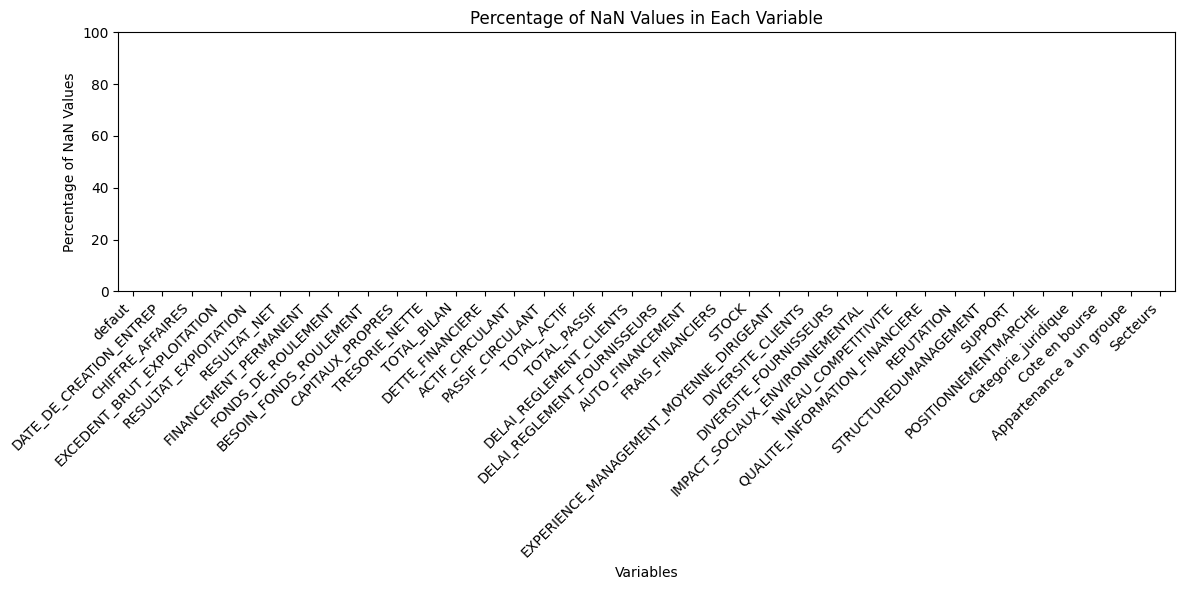

In [ ]:
# Calculate the percentage of NaN values in each column
nan_percentage = (df.isnull().mean() * 100).round(2)

# Create a bar plot to visualize the percentage of NaN values
plt.figure(figsize=(12, 6))
sns.barplot(x=nan_percentage.index, y=nan_percentage.values, palette='viridis')
plt.title('Percentage of NaN Values in Each Variable')
plt.xlabel('Variables')
plt.ylabel('Percentage of NaN Values')
plt.ylim(0, 100)  # Set y-axis limits from 0 to 100
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()

# Display the plot
plt.show()

we have 0% missing values which makes our work easier because we wont have to try to fill in these values or eliminate them

**Distribution of Defaut Values**

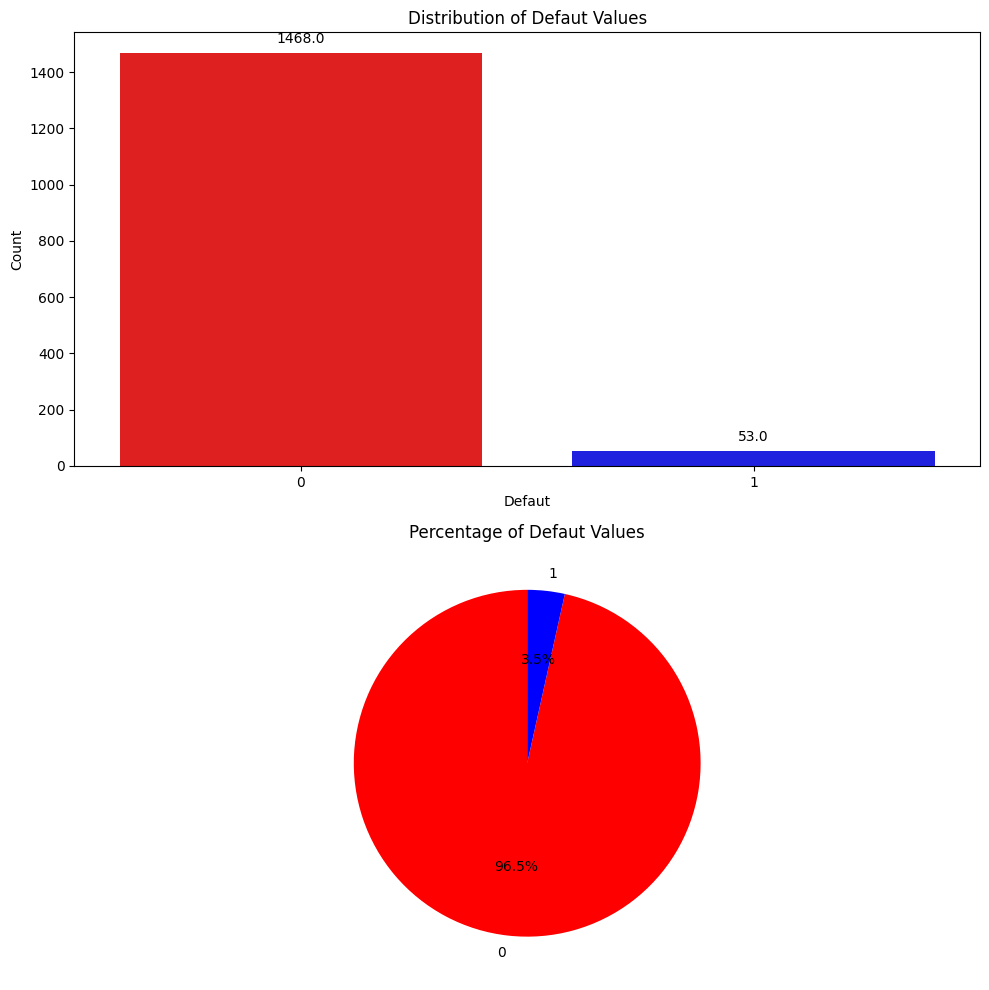

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))
ax1 = sns.countplot(x='defaut', data=df, palette=['red', 'blue'], ax=axes[0])
ax1.set_title('Distribution of Defaut Values')
ax1.set_xlabel('Defaut')
ax1.set_ylabel('Count')
for p in ax1.patches:
    ax1.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')
ax2 = axes[1]
defaut_counts = df['defaut'].value_counts()
ax2.pie(defaut_counts, labels=defaut_counts.index, autopct='%1.1f%%', startangle=90, colors=['red', 'blue'])
ax2.set_title('Percentage of Defaut Values')
plt.tight_layout()
plt.show()


we can see that our dataset is very inbalanced which is problematic , therefor we have to solve this issue before we get on with our modeling .

**Different Ratios**

these are some financial ratios that can give us some insights.

In [ ]:
df['current_ratio']=df['ACTIF_CIRCULANT']/df['PASSIF_CIRCULANT']
print(df[['current_ratio','ACTIF_CIRCULANT','PASSIF_CIRCULANT']].head())

df['AVG_TOTAL_ASSETS']=(df['TOTAL_ACTIF'].shift(1)+df['TOTAL_ACTIF'])/2
df['total_asset_turnover']=df['CHIFFRE_AFFAIRES']/df['AVG_TOTAL_ASSETS']
print(df[['total_asset_turnover','CHIFFRE_AFFAIRES','AVG_TOTAL_ASSETS']].head())

df['debt_ratio']=df['DETTE_FINANCIERE']/df['TOTAL_PASSIF']
print(df[['debt_ratio','DETTE_FINANCIERE','TOTAL_PASSIF']].head())

df['return_on_sales']=df['RESULTAT_NET']/df['CHIFFRE_AFFAIRES']
print(df[['return_on_sales','RESULTAT_NET','CHIFFRE_AFFAIRES']].head())

                    current_ratio  ACTIF_CIRCULANT  PASSIF_CIRCULANT
NUMTIERS_ANNEE                                                      
5200000007513_2015       1.989460     1.404023e+08       70573059.45
5200000007513_2016       1.920346     1.466761e+08       76380032.99
5200000007934_2015       1.399271     4.845077e+07       34625711.22
5200000007934_2017       2.871341     5.390498e+07       18773453.54
5200000008051_2015       1.558652     1.106311e+08       70978735.17
                    total_asset_turnover  CHIFFRE_AFFAIRES  AVG_TOTAL_ASSETS
NUMTIERS_ANNEE                                                              
5200000007513_2015                   NaN       236073240.2               NaN
5200000007513_2016              1.258847       258386615.0      2.052565e+08
5200000007934_2015              1.428783       202426475.2      1.416775e+08
5200000007934_2017              2.933040       210917616.4      7.191093e+07
5200000008051_2015              1.412852       17198752

**Creating lists that will help us in manipulating our dataset**

In [ ]:
categories_features=list(df.select_dtypes('O').columns)
numeric_features=list(df.select_dtypes(('int64','float64')).columns)
time_features=list(df.select_dtypes('datetime64').columns)

**Numeric Features Analysis**

In [ ]:
df.groupby('defaut')[numeric_features].mean()

,defaut,CHIFFRE_AFFAIRES,EXCEDENT_BRUT_EXPLOITATION,RESULTAT_EXPlOITATION,RESULTAT_NET,FINANCEMENT_PERMANENT,FONDS_DE_ROULEMENT,BESOIN_FONDS_ROULEMENT,CAPITAUX_PROPRES,TRESORIE_NETTE,...,AUTO_FINANCEMENT,FRAIS_FINANCIERS,STOCK,Cote en bourse,Appartenance a un groupe,current_ratio,AVG_TOTAL_ASSETS,total_asset_turnover,debt_ratio,return_on_sales
defaut,,,,,,,,,,,,,,,,,,,,,
0,0.0,8.941431e+08,1.153820e+11,7.245291e+07,4.644329e+07,8.232638e+08,7.419040e+08,8.257607e+08,5.132204e+08,-8.345981e+07,...,5.107579e+07,2.818550e+07,2.121759e+08,0.037466,0.621253,NaN,1.416856e+09,1.142364,0.080688,-0.024052
1,1.0,5.936199e+08,5.757416e+07,2.628677e+07,-4.726305e+06,6.716191e+08,5.737573e+08,7.207664e+08,3.432616e+08,-1.470091e+08,...,8.445827e+05,3.696758e+07,2.605697e+08,0.056604,0.622642,2.018865,1.315460e+09,1.038698,0.126438,-0.394844


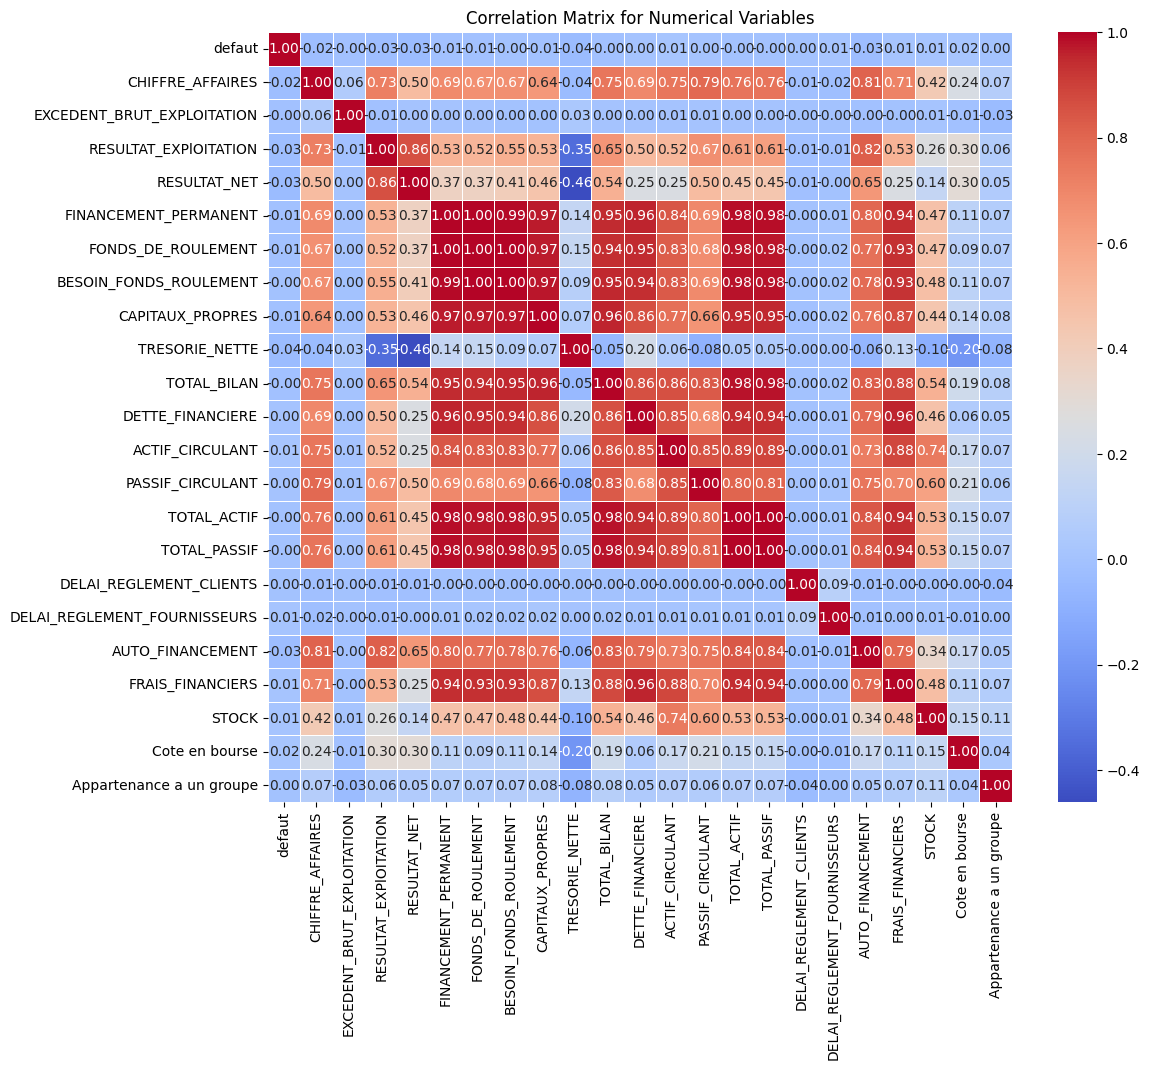

In [ ]:
df_numeric = df[numeric_features]

# Calculate the correlation matrix
correlation_matrix = df_numeric.corr()

# Create a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix for Numerical Variables')
plt.show()

we can see that the correlations with our target is rather quite low . therefore we need to plot a density plot to better observe the problem .

<ipython-input-48-be5a85317833>:14: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df[df['defaut'] == 0][feature], label='defaut = 0', fill=True, ax=ax)
<ipython-input-48-be5a85317833>:15: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df[df['defaut'] == 1][feature], label='defaut = 1', fill=True, ax=ax)


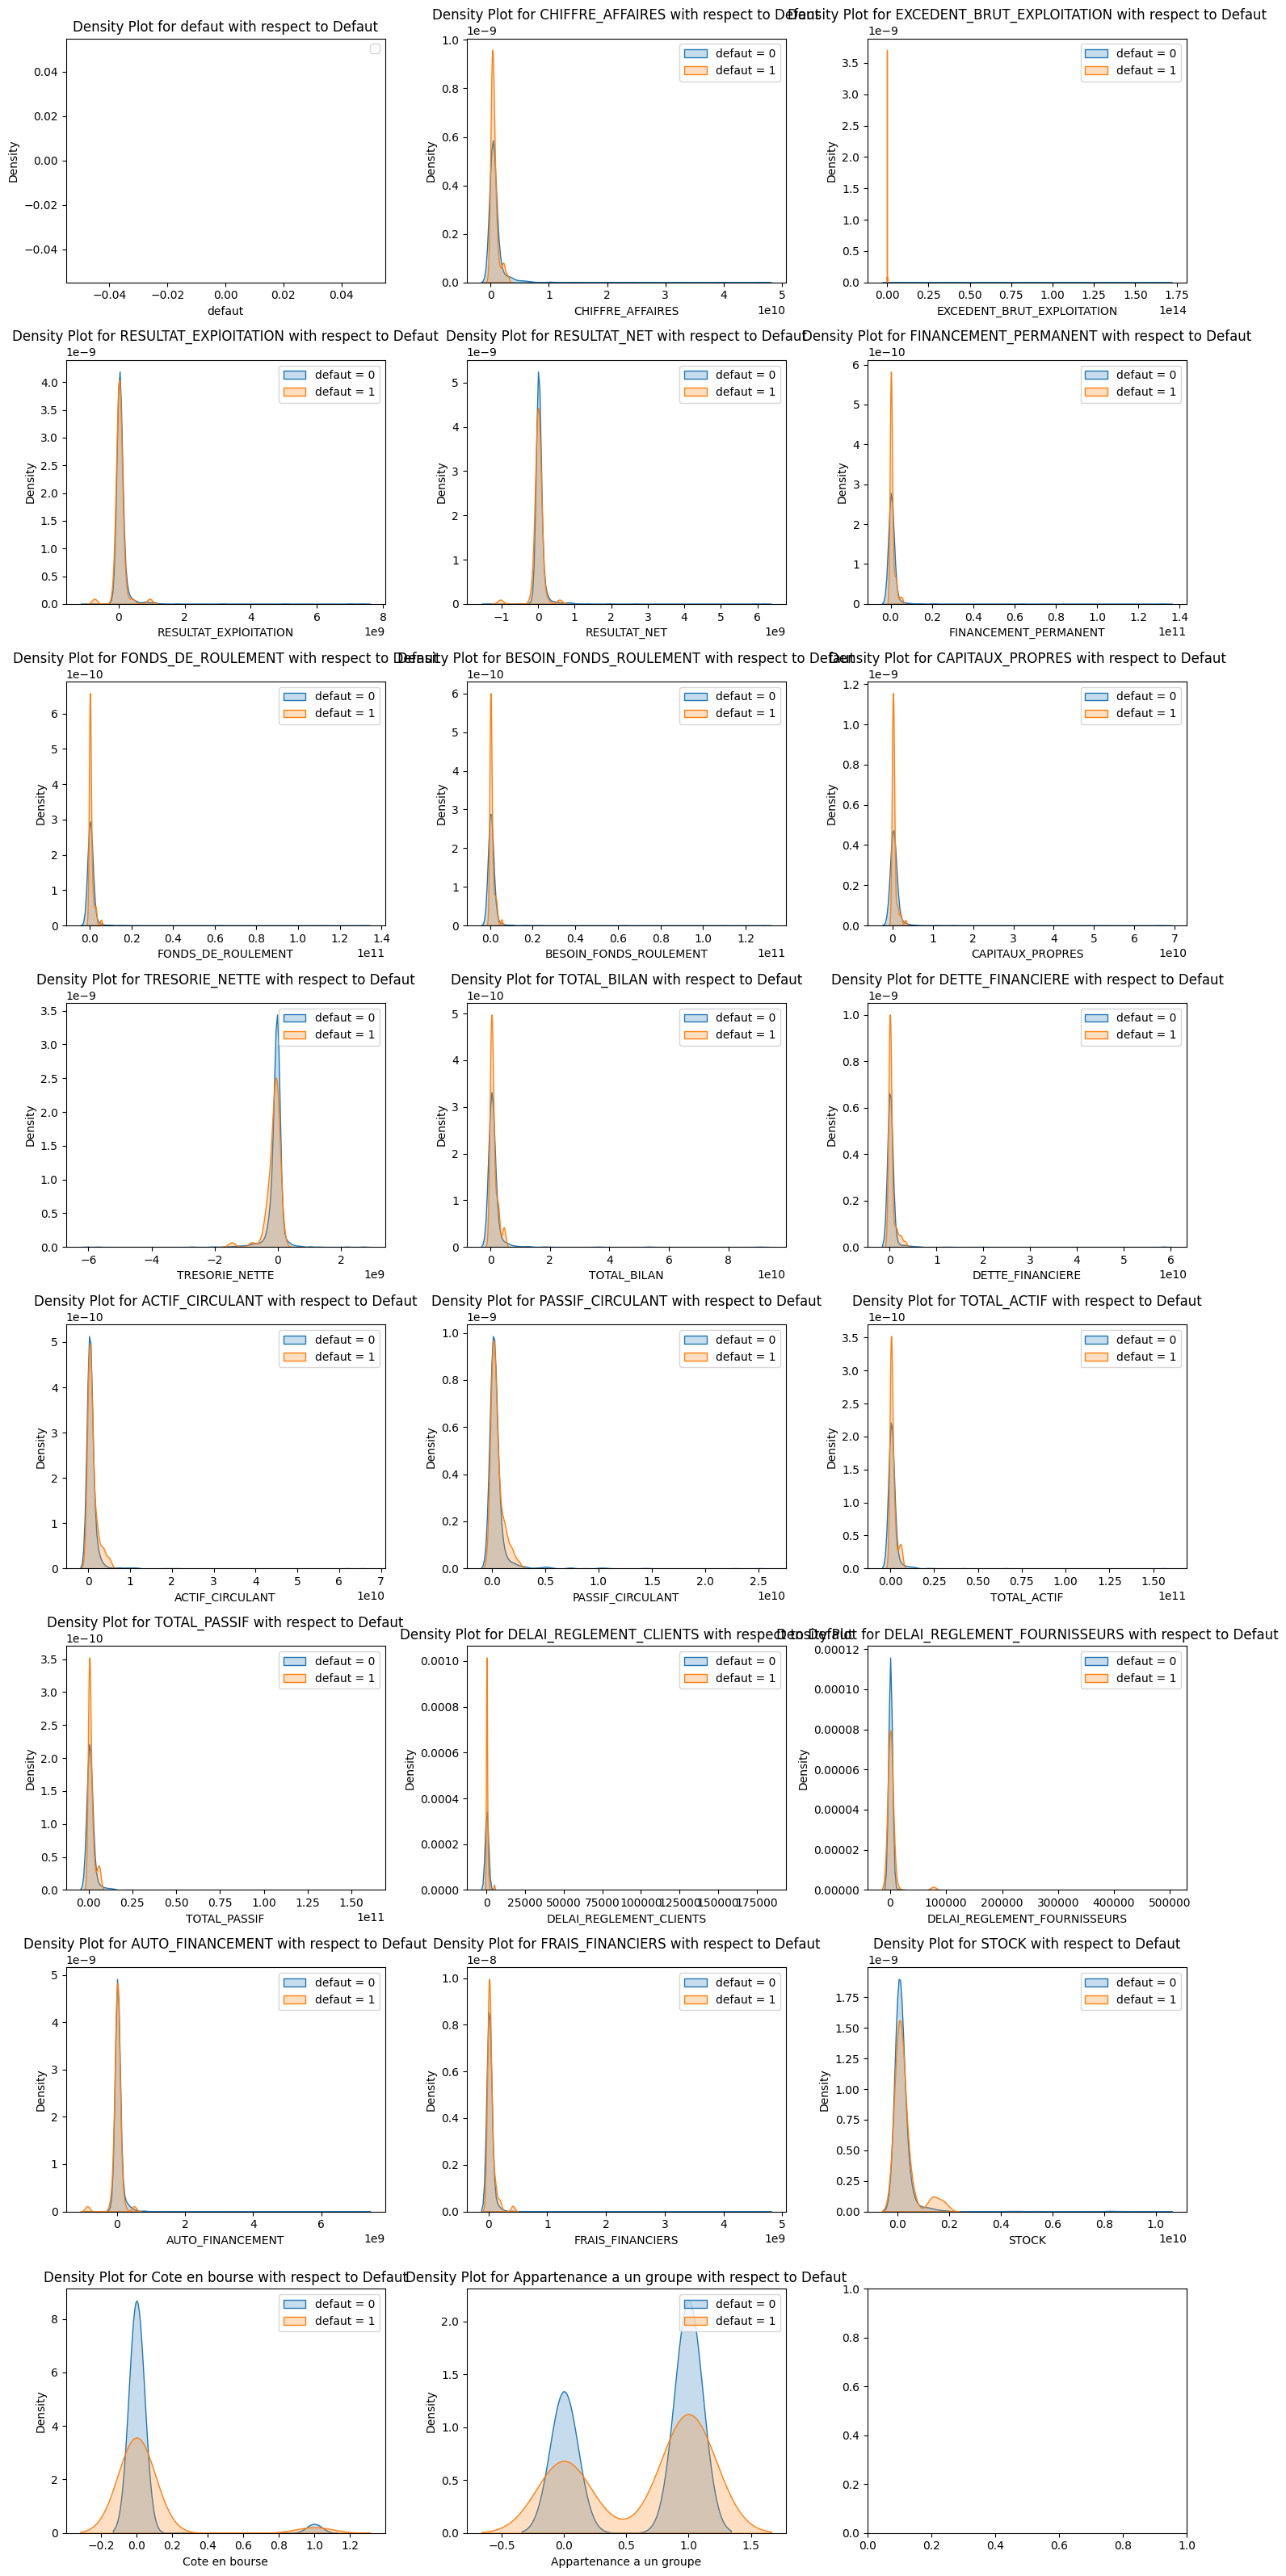

In [ ]:
# Create a grid layout for the density plots
num_plots = len(numeric_features)
num_cols = 3  # Adjust the number of columns as needed
num_rows = -(-num_plots // num_cols)  # Ceiling division to calculate the number of rows

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 4 * num_rows))

# Flatten the axes if there is only one row
axes = axes.flatten() if num_rows > 1 else [axes]

# Create density plots for numeric features
for i, feature in enumerate(numeric_features):
    ax = axes[i]
    sns.kdeplot(df[df['defaut'] == 0][feature], label='defaut = 0', fill=True, ax=ax)
    sns.kdeplot(df[df['defaut'] == 1][feature], label='defaut = 1', fill=True, ax=ax)
    ax.set_title(f'Density Plot for {feature} with respect to Defaut')
    ax.set_xlabel(feature)
    ax.set_ylabel('Density')
    ax.legend()

# Adjust layout
plt.tight_layout()
plt.show()


as we can see here , the densities for both 0 and 1 values of "defaut" are distributed in the same manner and the variables have low varience which in order explains the low correlations values .

**Categorical Features Analysis**

In [ ]:
# Sort the results based on the count of unique values
sorted_features = sorted(categories_features, key=lambda x: df[x].nunique(), reverse=True)
print("\nSorted by count:")
for feature in sorted_features:
    unique_values_count = df[feature].nunique()
    print(f"{feature}: {unique_values_count}")


Sorted by count:
Secteurs: 17
DIVERSITE_CLIENTS: 7
DIVERSITE_FOURNISSEURS: 6
IMPACT_SOCIAUX_ENVIRONNEMENTAL: 6
NIVEAU_COMPETITIVITE: 5
REPUTATION: 5
SUPPORT: 5
EXPERIENCE_MANAGEMENT_MOYENNE_DIRIGEANT: 4
QUALITE_INFORMATION_FINANCIERE: 4
STRUCTUREDUMANAGEMENT: 4
POSITIONNEMENTMARCHE: 4
Categorie_juridique: 3


In [ ]:
for feature in categories_features:
    print(f"\nCount of values for {feature}:")
    print(df[feature].value_counts())


Count of values for EXPERIENCE_MANAGEMENT_MOYENNE_DIRIGEANT:
Plus de 10 ans        1145
Entre 5 et 10 ans      296
Modalite vide           65
Inferieure e 5 ans      15
Name: EXPERIENCE_MANAGEMENT_MOYENNE_DIRIGEANT, dtype: int64

Count of values for DIVERSITE_CLIENTS:
Diversification tres forte par produits, clients, situation geographique                        1146
Bonne diversification par produits mais limitee e une zone geographique ou e quelques client     313
Forte dependance e quelques clients mais limitee e un seul produit                                40
Diversification limitee e un seul client ou un seul produit ou e une seule zone geographique      19
Diversification très forte par produits,clients, situation geographique                            1
Diversification très forte par produits, clients, situation geographique                           1
Modalite vide                                                                                      1
Name: DIVERSITE_CLIENTS

In [ ]:
df['REPUTATION'].replace('Tres bonne','Très bonne',inplace=True)
df['DIVERSITE_FOURNISSEURS'].replace('Tres grande diversite','Très grande diversite',inplace=True)
df['DIVERSITE_CLIENTS'].replace("Diversification tres forte par produits, clients, situation geographique",'Diversification trés forte par produits, clients, situation geographique',inplace=True)
df['DIVERSITE_FOURNISSEURS'].replace('Trés grande diversite','Très grande diversite',inplace=True)
df['NIVEAU_COMPETITIVITE'].replace('Tres forte concurrence','Très forte concurrence',inplace=True)
df['IMPACT_SOCIAUX_ENVIRONNEMENTAL'].replace('Aucun impact social ou environnemental, soumis e une reglementation','Aucun impact social ou environnemental, soumis à une reglementation',inplace=True)

we have observed some anamolies within the values of some of our categorical variables . and we have solved this issue .

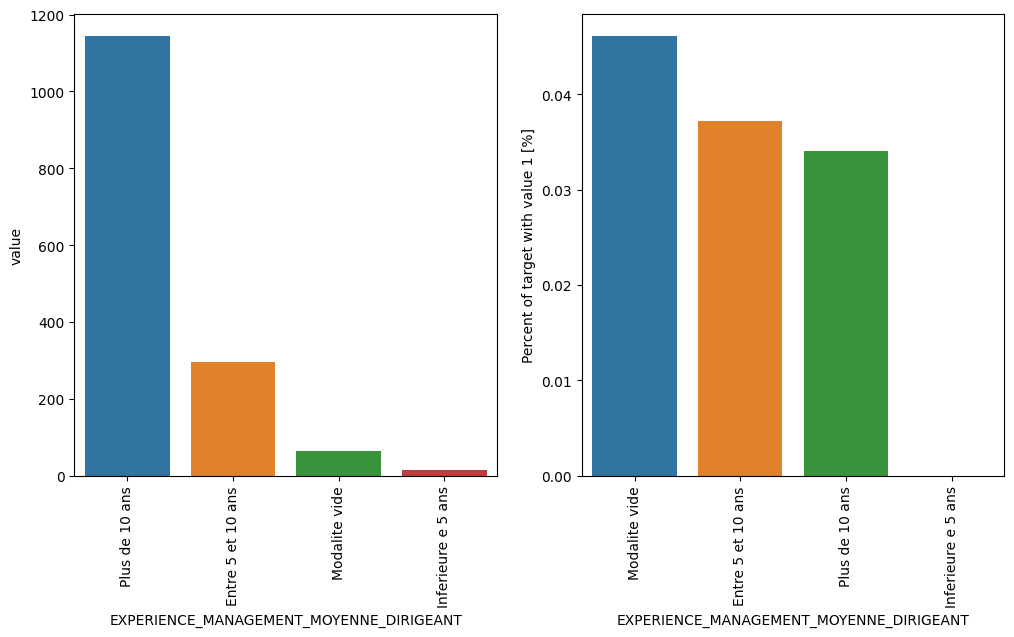

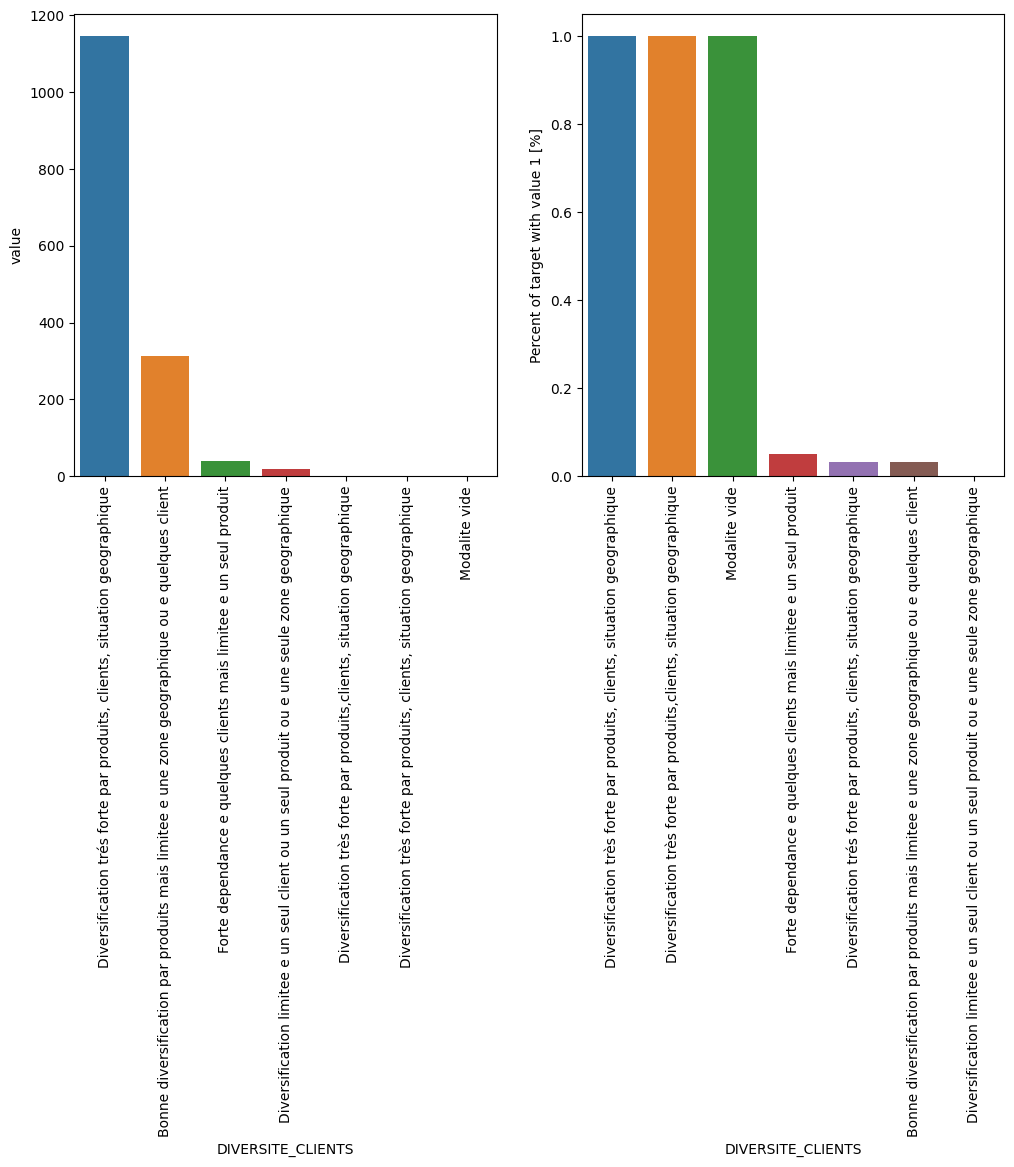

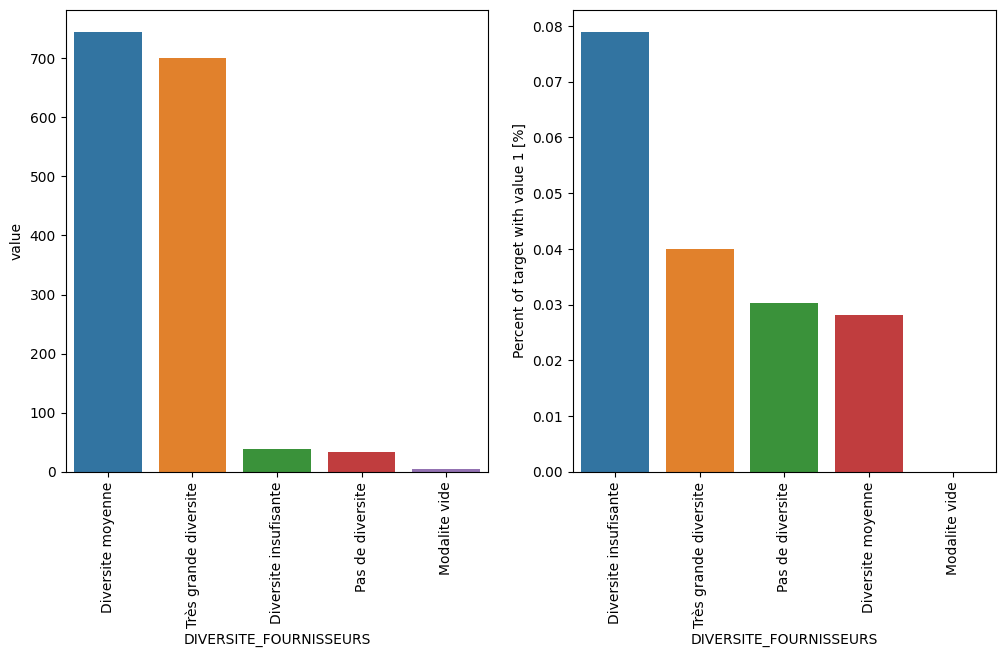

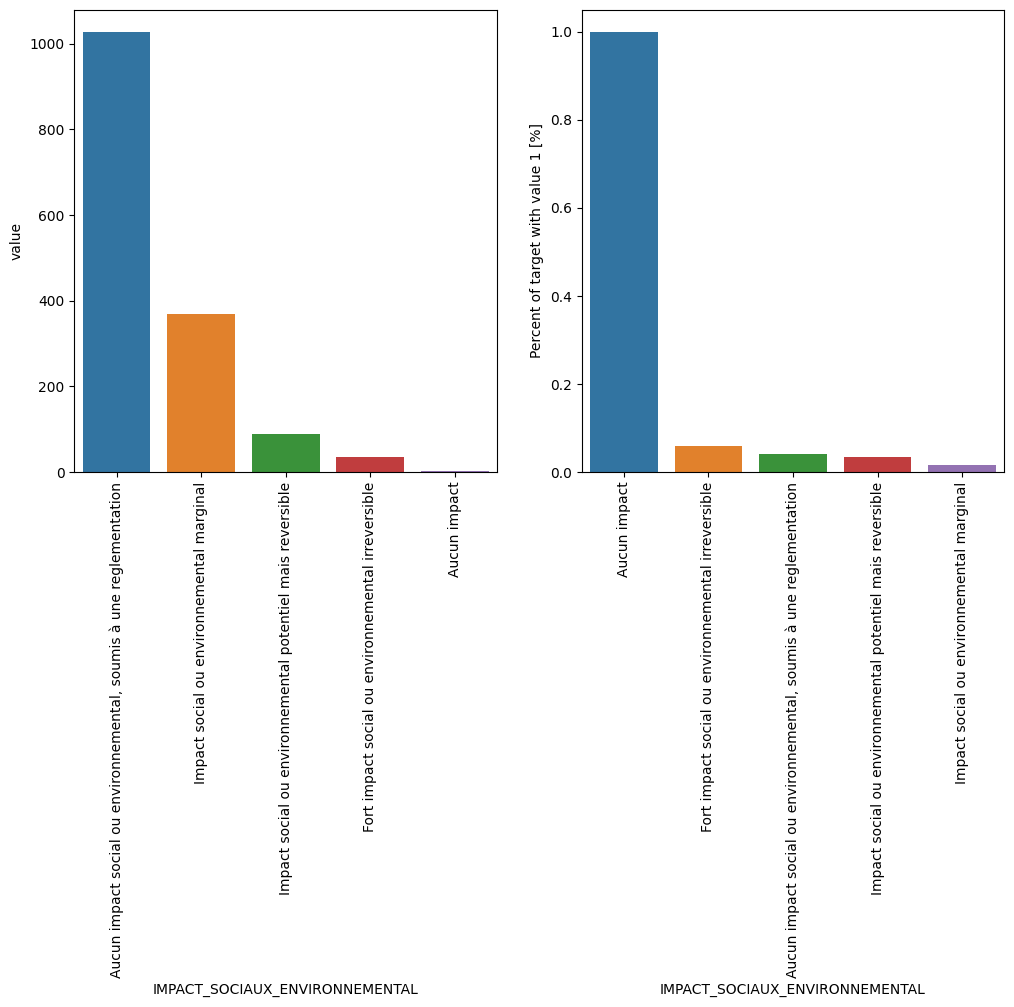

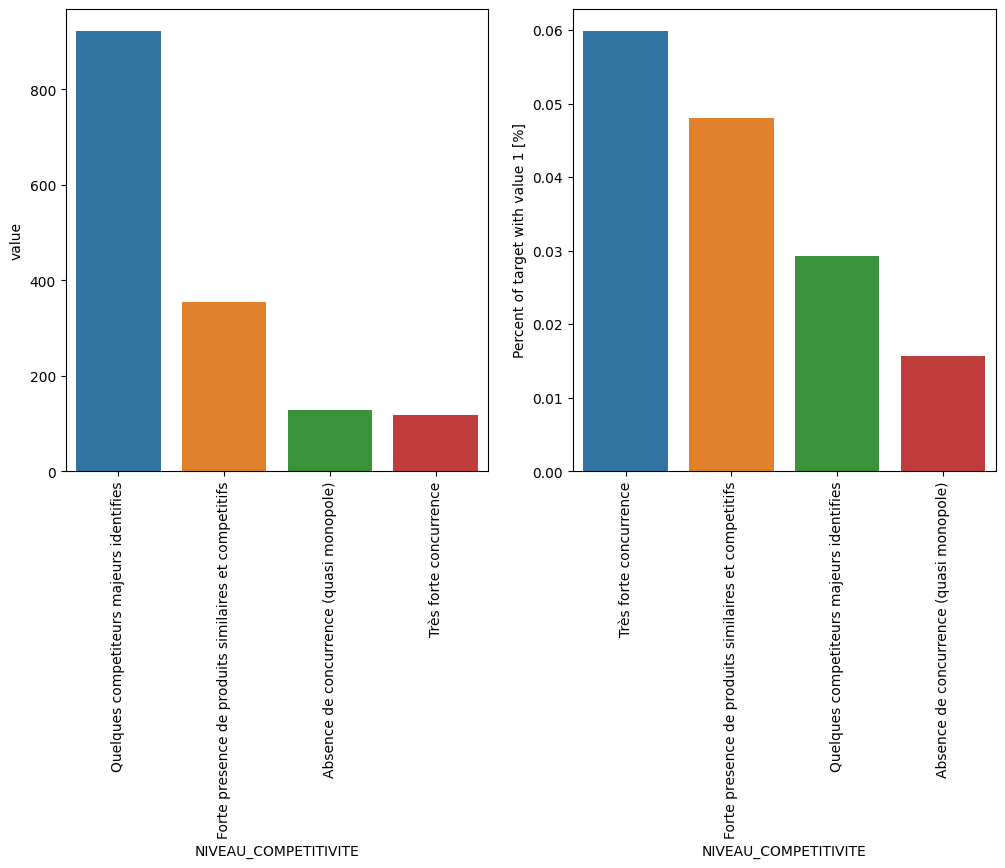

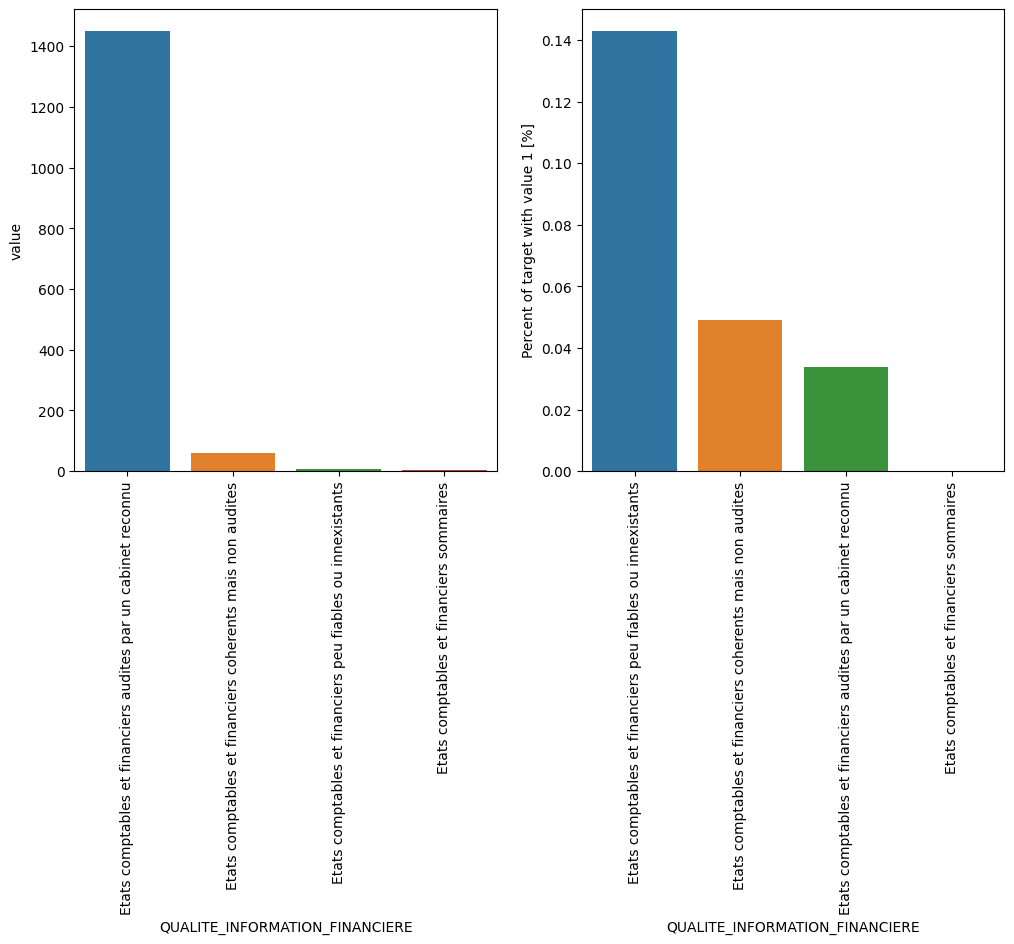

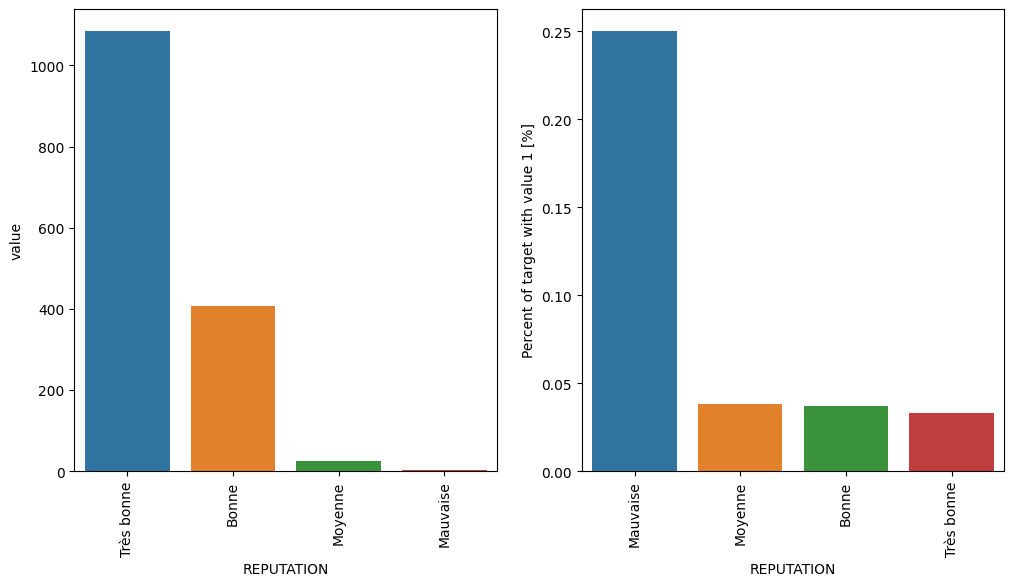

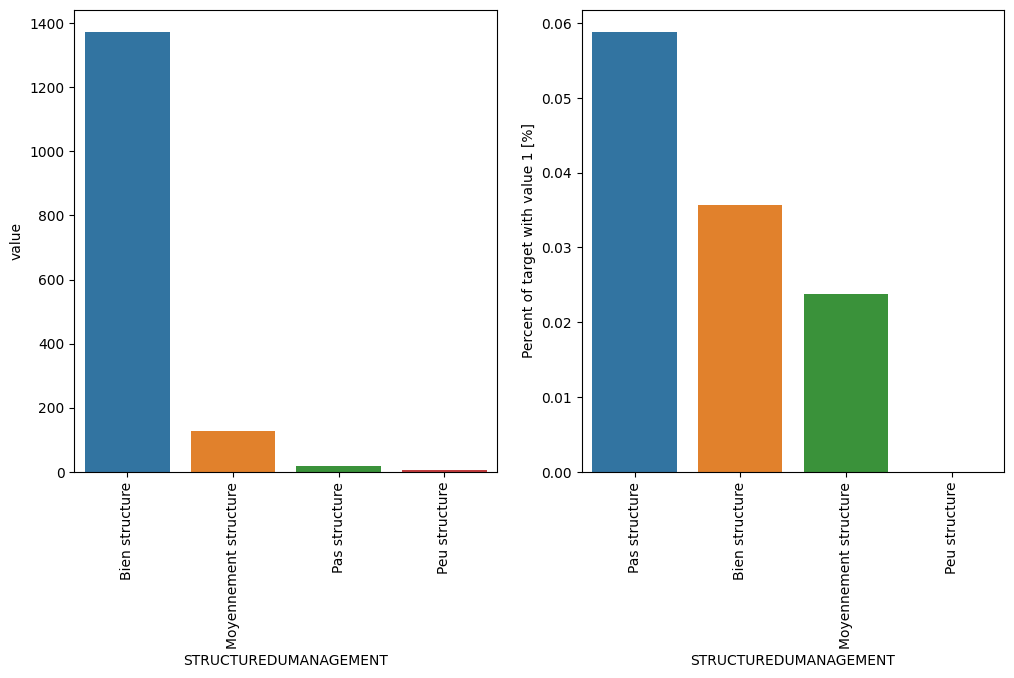

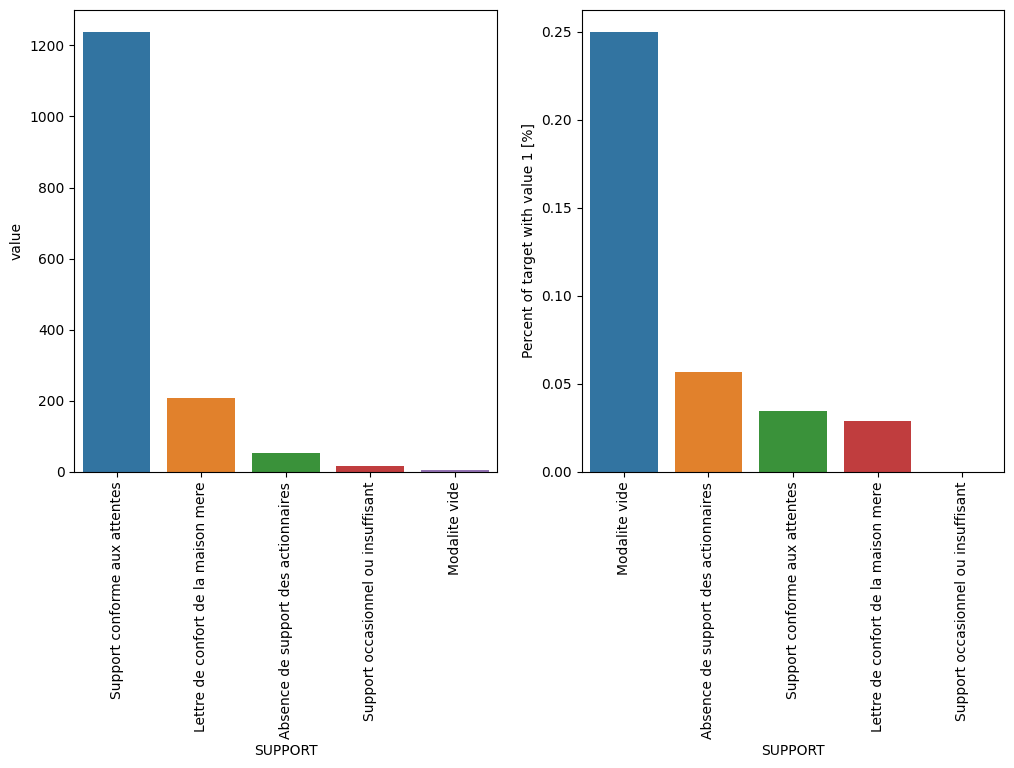

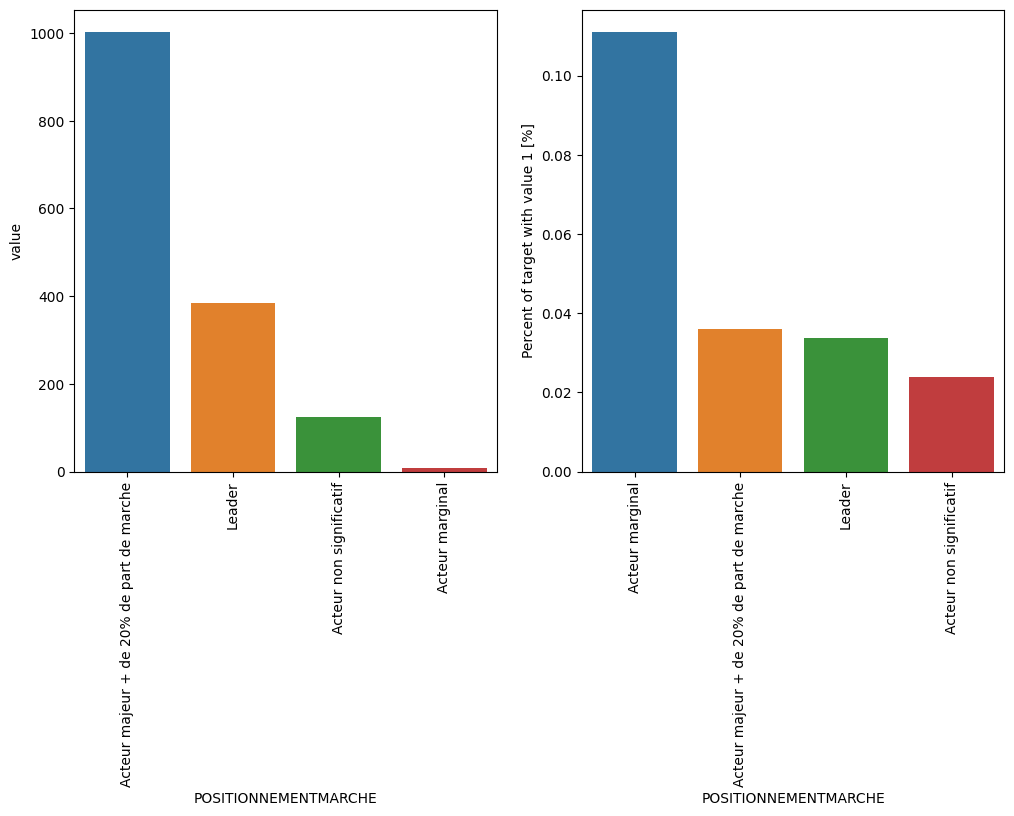

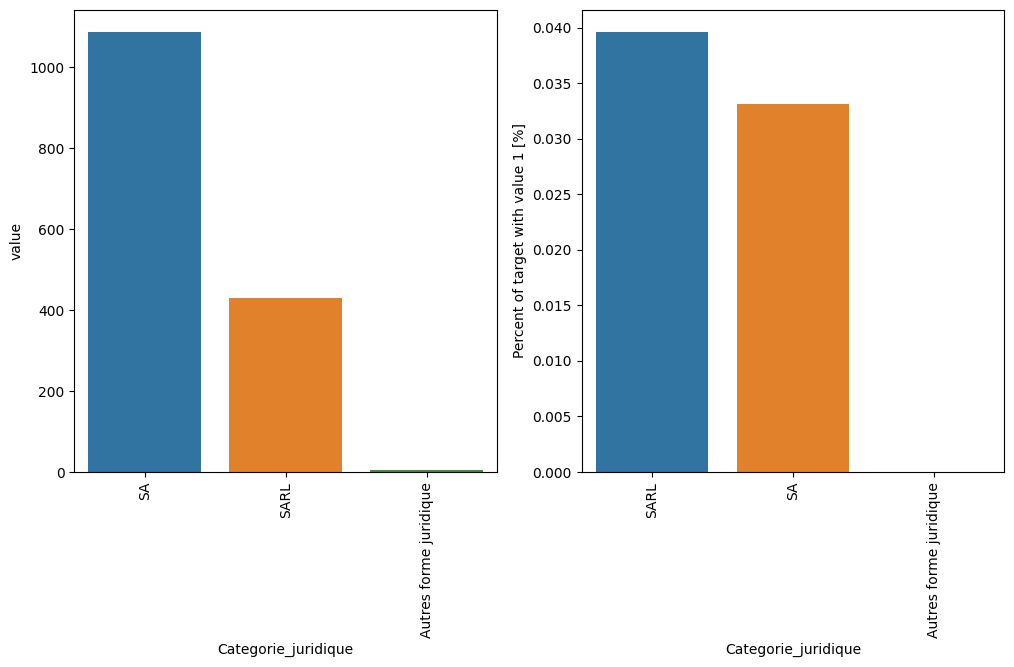

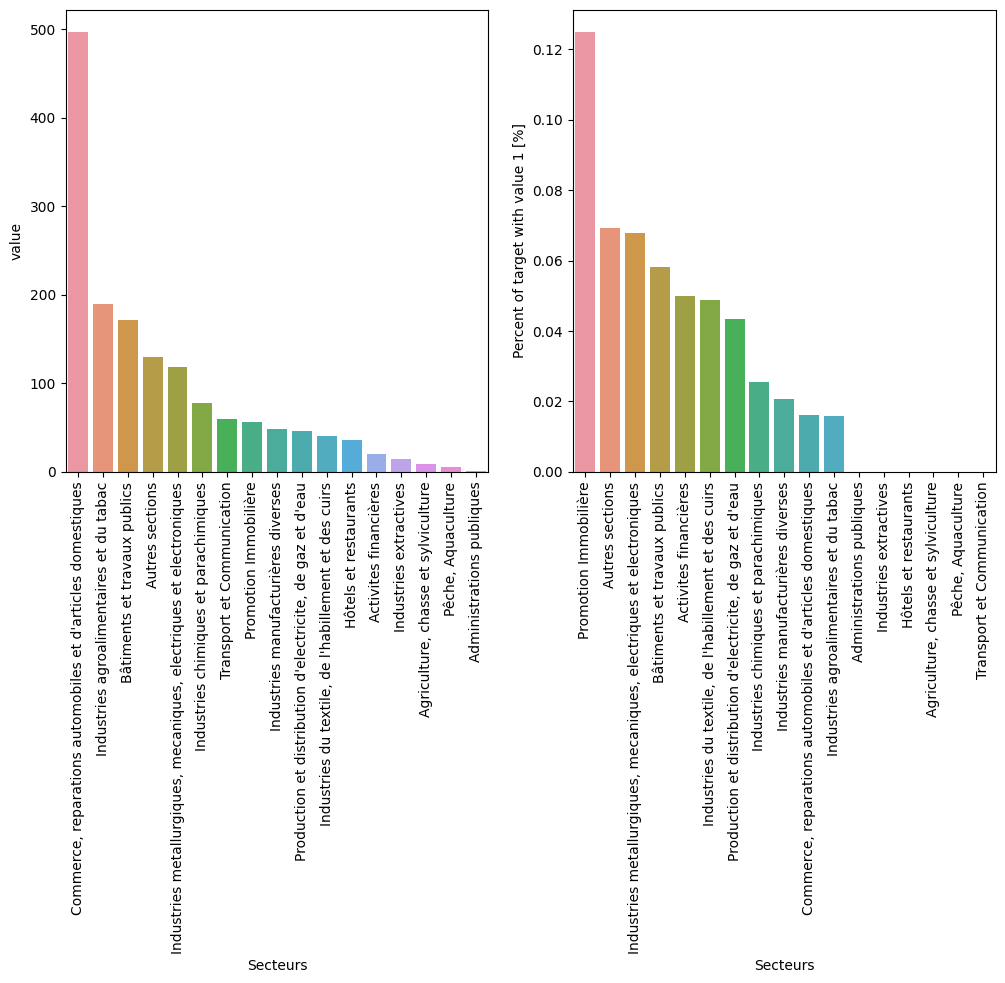

In [ ]:
for feature in categories_features:
    temp = df[feature].value_counts()
    df1 = pd.DataFrame({feature: temp.index, 'value': temp.values})
    cat_perc = df[[feature, 'defaut']].groupby([feature], as_index=False).mean()
    cat_perc.sort_values(by='defaut', ascending=False, inplace=True)

    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))

    sns.set_color_codes("pastel")
    s = sns.barplot(ax=ax1, x=feature, y="value", data=df1)
    s.set_xticklabels(s.get_xticklabels(), rotation=90)

    s = sns.barplot(ax=ax2, x=feature, y='defaut', data=cat_perc)
    s.set_xticklabels(s.get_xticklabels(), rotation=90)
    plt.ylabel('Percent of target with value 1 [%]', fontsize=10)
    plt.tick_params(axis='both', which='major', labelsize=10)

    plt.show()

In [ ]:
imputer=SimpleImputer(missing_values='Modalite vide',strategy='most_frequent')
df=pd.DataFrame(imputer.fit_transform(df),columns=df.columns)
df[numeric_features]=df[numeric_features].astype('float64')

according the these histograms , the "modalite vide" is acctualy quite important and removing it from our dataset may lead to a huge informational loss , therefore we have opted for imputing them using the "most frequent" strategy .

**Anova Test for Categorical features and their Importance to our target variable**

In [ ]:
# Assuming 'df' is your DataFrame with categorical features and the 'defaut' variable
categories_features = list(df.select_dtypes('O').columns)

# Create an empty list to store the ANOVA results
data_anova = []

# Perform ANOVA for each categorical variable
for variable in categories_features:
    formula = f'defaut ~ C({variable})'
    model = ols(formula, data=df).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)

    data_anova.append({
        'Variable': variable,
        'F-statistic': anova_table['F']['C(' + variable + ')'],
        'P-value': anova_table['PR(>F)']['C(' + variable + ')']
    })

# Convert the list of dictionaries to a DataFrame
df_anova = pd.DataFrame(data_anova)

# Display the ANOVA results
print(df_anova)


                                   Variable  F-statistic       P-value
0   EXPERIENCE_MANAGEMENT_MOYENNE_DIRIGEANT     0.294254  7.451297e-01
1                         DIVERSITE_CLIENTS    11.680568  4.258999e-11
2                    DIVERSITE_FOURNISSEURS     1.263740  2.853155e-01
3            IMPACT_SOCIAUX_ENVIRONNEMENTAL     8.365779  1.128282e-06
4                      NIVEAU_COMPETITIVITE     2.087456  9.999348e-02
5            QUALITE_INFORMATION_FINANCIERE     0.996342  3.936232e-01
6                                REPUTATION     1.885692  1.300264e-01
7                     STRUCTUREDUMANAGEMENT     0.318174  8.122509e-01
8                                   SUPPORT     0.534620  6.585872e-01
9                      POSITIONNEMENTMARCHE     0.678327  5.653206e-01
10                      Categorie_juridique     0.267543  7.652936e-01
11                                 Secteurs     2.369637  1.715077e-03


here we have sorted the p values of all our categorical variables , and its wise to choose only the variables with a p value over 0.05 for a better model accuracy .

**Incoding the Ordinal categorical variables**

In [ ]:
df['EXPERIENCE_MANAGEMENT_MOYENNE_DIRIGEANT'].replace(['Plus de 10 ans', 'Entre 5 et 10 ans', 'Inferieure e 5 ans'],(0,1,2),inplace=True)
df['DIVERSITE_FOURNISSEURS'].replace(['Pas de diversite', 'Diversite moyenne', 'Diversite insufisante', 'Très grande diversite'],(0,1,2,3),inplace=True)
df['REPUTATION'].replace(['Mauvaise', 'Moyenne', 'Bonne', 'Très bonne'],(0,1,2,3),inplace=True)
df['STRUCTUREDUMANAGEMENT'].replace(['Pas structure','Peu structure',  'Moyennement structure' ,'Bien structure'],(0,1,2,3),inplace=True)

**Incoding the nominal Categorical variables**

In [ ]:
df=pd.get_dummies(df)

In [ ]:
boolean_columns = df.select_dtypes('bool').columns
df[boolean_columns] = df[boolean_columns].astype(int)

**Splitting our data into test and train sets**

In [ ]:
df = df.drop('DATE_DE_CREATION_ENTREP', axis=1)

In [ ]:
X=df.copy()
X=X.drop('defaut',axis=1)
y=df['defaut']

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

**Applying SMOTE in order to balance the skewed dataset**

In [ ]:
# Apply SMOTE to the training set
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

now using SMOTE we have tried to even the odds and balance our dataset

**RANDOM FOREST CLASSIFIER**

Accuracy on the test set: 0.9671772428884027


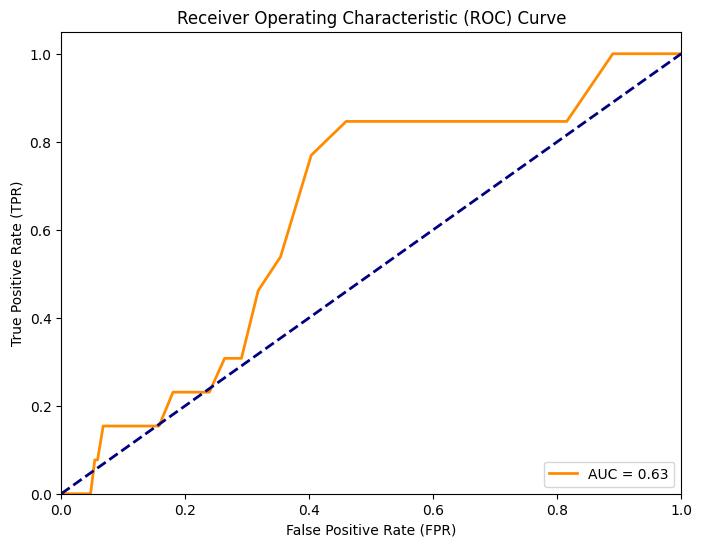

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE
# Create and train the RandomForestClassifier
model = RandomForestClassifier()
model.fit(X_train_smote, y_train_smote)
# Make predictions on the test set
y_pred = model.predict(X_test)
# Evaluate the performance of the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on the test set: {accuracy}")
# Get predicted probabilities for the positive class
y_probs = model.predict_proba(X_test)[:, 1]
# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)
# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


**DESCISION TREE CLASSIFIER**

Accuracy on the test set: 0.936542669584245


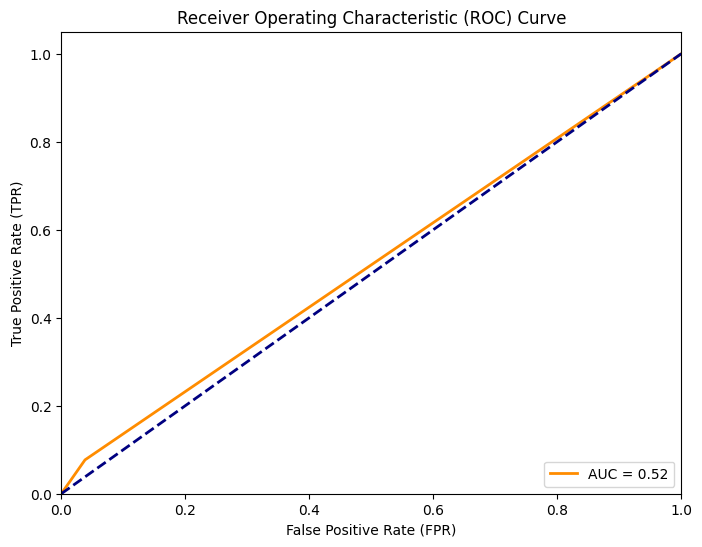

In [ ]:
# Create and train the DecisionTreeClassifier
model_dt = DecisionTreeClassifier()
model_dt.fit(X_train_smote, y_train_smote)

# Make predictions on the test set
y_pred = model_dt.predict(X_test)

# Evaluate the performance of the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on the test set: {accuracy}")

# Get predicted probabilities for the positive class
y_probs = model_dt.predict_proba(X_test)[:, 1]  # DecisionTreeClassifier has predict_proba method

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

**LOGISTIC REGRESSION MODEL**

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy on the test set: 0.6652078774617067


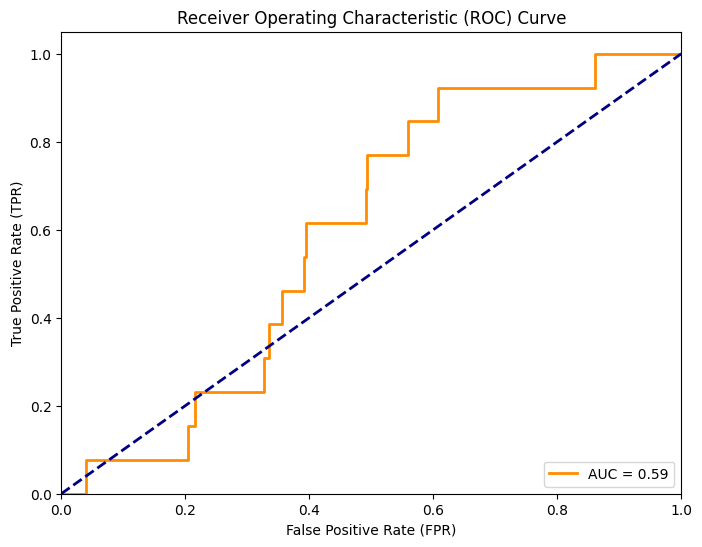

In [ ]:
# Create and train the Logistic Regression model
model_lr = LogisticRegression()
model_lr.fit(X_train_smote, y_train_smote)

# Make predictions on the test set
y_pred = model_lr.predict(X_test)

# Evaluate the performance of the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on the test set: {accuracy}")

# Get predicted probabilities for the positive class
y_probs = model_lr.predict_proba(X_test)[:, 1]  # Logistic Regression has predict_proba method

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

Conclusion : the random forest classifier is the best model from the 3 that we have implemented with an accuracy of 0.967 and an auc of 0.63